In [1]:
# GET PARAMETERS
import os 
import sys
import pandas as pd
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.train_and_visu_non_recurrent import evaluate_config,get_ds,train_the_config,get_ds_without_shuffling_on_train_set
from plotting.plotting import error_per_station_calendar_pattern,gain_between_models
from examples.train_model_on_k_fold_validation import load_configuration
from constants.paths import SAVE_DIRECTORY
from high_level_DL_method import load_model,load_optimizer_and_scheduler
from examples.load_best_config import load_args_of_a_specific_trial
from trainer import Trainer
import torch 

def get_trainer_and_ds_from_saved_trial(trial_id,add_name_id,save_folder,modification,fold_to_evaluate = None):
    # Load Data and Init Model:
    if fold_to_evaluate is None:
        fold_name = 'complete_dataset'
    else:
        fold_name = fold_to_evaluate[0]

    #args,_ = load_configuration(trial_id1,load_config=True)
    args = load_args_of_a_specific_trial(trial_id,add_name_id,save_folder,fold_name)

    if fold_to_evaluate is None:  fold_to_evaluate = [args.K_fold-1]

    
           
    ds,_,_,_,_ =  get_ds(args_init=args,modification = modification,fold_to_evaluate=fold_to_evaluate)
    model = load_model(ds, args)


    # Load Trained Weights 
    model_param = torch.load(f"{current_path}/{SAVE_DIRECTORY}/{save_folder}/best_models/{trial_id}{add_name_id}_f{fold_name}.pkl")
    model.load_state_dict(model_param['state_dict'],strict=True)


    # Load Trainer : 
    optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args)
    trainer = Trainer(ds,model,args,optimizer,loss_function,scheduler = scheduler)

    return trainer,ds,args


Training and Hyper-parameter tuning with Ray is not possible


# Load Both models to compare : 

In [2]:
modification = {'shuffle':False,
                'data_augmentation':False }

# Load Model1:
save_folder1 = 'K_fold_validation/training_with_HP_tuning/re_validation'
add_name_id1 = ''
trial_id1 ='subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'
trainer1,ds1,args1 = get_trainer_and_ds_from_saved_trial(trial_id1,add_name_id1,save_folder1,modification)

# Load Model2: 
#Trained Model with Subway-in / Subway-out 
if False:
    save_folder2 = 'K_fold_validation/training_with_HP_tuning/re_validation'
    add_name_id2 = 'concat_early'
    trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 
    trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder2,modification)

#Trained Model with Subway-in / NetMob POI:
if True: 
    save_folder2 = 'K_fold_validation/training_with_HP_tuning/re_validation'
    add_name_id2 = 'NETMOB_POIS_maps_Twitter_concat_early_late_UL_DL_all_tags'
    trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 
    trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder2,modification)

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 


Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481

Init Dataset: 'torch.Size([4597, 40]) with 183880 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([2940, 40, 7])/torch.Size([2940, 40, 1]) Train/Valid/Test 1059 941 939

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Model size: 0.000GB
number of total parameters: 71713
number of trainable parameters: 71713
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40

## Get Metrics from trained model. Compared consistency with saved one : 
Nous permets de nous assurer qu'on à bien sauvegarder le meiolleur model, et que c'est bien celui qu'on Load.

In [3]:
def display_consistency(trainer,ds,save_folder,trial_id,add_name_id,training_mode = 'test'):
    full_predict1,Y_true,_ = trainer.testing(ds.normalizer, training_mode =training_mode)
    Y_true= Y_true.detach().clone().reshape(-1)    
    full_predict1= full_predict1.detach().clone().reshape(-1)    
    error_pred1 = ((Y_true - full_predict1)**2).mean()

    df_metrics1 = pd.read_csv(f"{current_path}/{SAVE_DIRECTORY}/{save_folder}/METRICS_{trial_id}{add_name_id}.csv")
    display(df_metrics1)
    print(f"MSE errror on {training_mode} by loading trained model : {'{:.2f}'.format(error_pred1.item())}")

if True:
    display_consistency(trainer2,ds2,save_folder2,trial_id2,add_name_id2,training_mode = 'test')

,Unnamed: 0,mse,mae,mape,VAR_mse,VAR_mae,VAR_mape,mse_complete_ds,mae_complete_ds,mape_complete_ds
0,valid,1324.763184,21.642506,36.200874,7944.388301,0.436605,10.932614,1250.250854,21.195671,32.322041
1,test,1366.276001,21.950677,34.394472,4432.022240,0.823113,35.609372,1338.346436,21.048252,26.952559


MSE errror on test by loading trained model : 1338.35


## Plot Gains between Two trained Models:
Retourne le gain de Model 2 par rapport à Model 1

In [68]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from plotting.plotting import get_gain_from_mod1,plot_matshow,plot_coverage_matshow



def get_gain_from_mod1(real,predict1,predict2,previous,min_flow,metrics = ['mse'],acceptable_error= 0,mape_acceptable_error=0):
    '''

    args:
    -----
    
    '''
    dic_gain,dic_error = {},{}
    real = real.detach().clone().reshape(-1)
    previous = previous.detach().clone().reshape(-1)  

    predict1 = predict1.detach().clone().reshape(-1)    
    predict2 = predict2.detach().clone().reshape(-1)   

    mask = real>min_flow

    # Tackle metrics: 
    for metric in metrics:
        if metric == 'mse':
            error_pred1 = (real - predict1)**2
            error_pred2 = (real - predict2)**2
            local_acceptable_error = acceptable_error**2
        elif metric == 'mae':
            error_pred1 = abs(real - predict1)
            error_pred2 = abs(real - predict2)
            local_acceptable_error = acceptable_error
        elif metric == 'mape':
            error_pred1 = torch.full(real.shape, -1.0)  # Remplir avec -1 par défaut
            error_pred2 = torch.full(real.shape, -1.0)  # Remplir avec -1 par défaut
            error_pred1[mask] = 100 * (torch.abs(real[mask] - predict1[mask]) / real[mask]) 
            error_pred2[mask] = 100 * (torch.abs(real[mask] - predict2[mask]) / real[mask]) 
            local_acceptable_error = mape_acceptable_error
        else:
            raise NotImplementedError
        dic_error[metric] = {'error_pred1':error_pred1,
                             'error_pred2':error_pred2}


        # In case the reference error (model1), is too small, we use an 'acceptable error' 
        cloned_error_pred1 = error_pred1.clone()
        local_mask = error_pred1 <  local_acceptable_error
        cloned_error_pred1[local_mask] = local_acceptable_error  
        gain = 100*(error_pred2-error_pred1)/cloned_error_pred1

        dic_gain[metric] = gain

    # Tackle Naiv :
    if 'mae' in metrics: 
        error_naiv = abs(real-previous)
        gain_naiv1 = dic_error['mae']['error_pred1']-error_naiv
        gain_naiv2 = dic_error['mae']['error_pred2']-error_naiv
        dic_error['mase'] = {'error_pred1':gain_naiv1,
                            'error_pred2':gain_naiv2}
        dic_error['mae_naiv'] = {'error_naiv':error_naiv}
        # ....

    return dic_gain,dic_error

def get_fig_size(nb_station_to_plots,columns_matshow):
    y_size = nb_station_to_plots*5
    if columns_matshow is None:
        x_size = 10
    else:
        x_size = 30
    figsize = (x_size,y_size)
    return figsize


def plot_gains(ds1,column,station_ind,training_mode,dic_error,freq,index_matshow,columns_matshow, metrics,v_min,v_max,cmap,bool_reversed,axes):
    for ind_metric,metric_i in enumerate(metrics) : 
        cbar_label = f"Gain {metric_i}"
        # Build Matshow matrix : 
        df_agg = build_matrix_for_matshow(ds1,column,training_mode,dic_error[metric_i],freq,index_matshow,columns_matshow)

        # Plotting : 
        plot_matshow(df_agg,column,metric_i,v_min,v_max,cmap,cbar_label,bool_reversed,axes,station_ind,ind_metric)      



def gain_between_models(trainer1,trainer2,ds1,ds2,training_mode,
                         metrics = ['mse','mae','mape'],
                        freq='1h',
                        index_matshow = 'day_date',
                        columns_matshow = 'hour',
                        min_flow = 20,
                        limit_percentage_error = 300,
                        acceptable_error = 10,
                        stations = None,
                        plot_each_station = False,
                        plot_all_station = True

                         ):
    '''

    '''
    # Init:
    if stations is not None:
        n_station = len(stations) 
    else:
        n_station = len(ds1.spatial_unit)
        stations = list(ds1.spatial_unit)

    nb_station_to_plots = plot_each_station*n_station + plot_all_station
    fig, axes = plt.subplots(nb_station_to_plots, len(metrics), figsize=get_fig_size(nb_station_to_plots,columns_matshow))

    # Get Pred1,Pred2, TrueValues:
    full_predict1,Y_true,_ = trainer1.testing(ds1.normalizer, training_mode =training_mode)
    full_predict2,_,_ = trainer2.testing(ds2.normalizer, training_mode =training_mode)
    inputs = [[x,y,x_c] for  x,y,x_c in ds1.dataloader[training_mode]]
    previous  = torch.cat([x for x,_,_ in inputs],0)
    previous  = ds1.normalizer.unormalize_tensor(inputs = previous,feature_vect = True) # unormalize input cause prediction is unormalized 

    # Set cmap:
    cmap = 'RdYlBu'
    bool_reversed = True
    v_min,v_max = -limit_percentage_error,limit_percentage_error

    # Evaluate Prediciton per stations:
    if plot_each_station:
        for station_ind in range(n_station):
            station_c = list(ds1.spatial_unit).index(stations[station_ind])
            column = stations[station_ind]

            dic_gain,dic_error = get_gain_from_mod1(real = Y_true[:,station_c:station_c+1,:],
                                        predict1 = full_predict1[:,station_c:station_c+1,:],
                                        predict2 = full_predict2[:,station_c:station_c+1,:],
                                        previous = previous[:,station_c:station_c+1,-1],
                                        min_flow=min_flow,metrics = metrics,acceptable_error= acceptable_error) 
            plot_gains(ds1,column,station_ind,training_mode,dic_gain,freq,index_matshow,columns_matshow, metrics,v_min,v_max,cmap,bool_reversed,axes)

    if plot_all_station:
        station_ind = n_station if plot_each_station else 1
        column = 'All'
        T,N,C = Y_true.size()
        dic_gain,dic_error = get_gain_from_mod1(real =Y_true,
                                    predict1 = full_predict1,
                                    predict2 = full_predict2,
                                    previous = previous[:,station_c:station_c+1,-1],
                                    min_flow=min_flow,metrics = metrics,acceptable_error= acceptable_error)
        dic_gain = {metric_i:error_i.reshape(T,N).mean(axis=1) for metric_i,error_i in dic_gain.items()}
        plot_gains(ds1,column,station_ind,training_mode,dic_gain,freq,index_matshow,columns_matshow, metrics,v_min,v_max,cmap,bool_reversed,axes)



    plt.tight_layout()
    plt.show()
    return fig,axes

def add_calendar_columns(df_agg,freq=None,key_columns=None,agg_func = 'sum'):
    if freq is not None:
        df_agg = df_agg.groupby([pd.Grouper(key = 'datetime',freq = freq)]).agg(agg_func).reset_index()
    if key_columns is not None:
        df_agg=df_agg[key_columns]
    df_agg['date']= df_agg.datetime.dt.date
    df_agg['day_date'] = df_agg.datetime.dt.day
    df_agg['month_year']= df_agg.datetime.dt.month.transform(lambda x : str(x)) + ' ' + df_agg.datetime.dt.year.transform(lambda x : str(x))
    df_agg['month_year']= pd.to_datetime(df_agg['month_year'],format = '%m %Y')
    #df_agg['hour']= df_agg.datetime.dt.hour.transform(lambda x : str(x)) + ':' + df_agg.datetime.dt.minute.transform(lambda x : str(x))
    df_agg['hour']= df_agg.datetime.dt.hour + df_agg.datetime.dt.minute*0.01
    df_agg['weekday']= df_agg.datetime.dt.weekday
    return df_agg

def build_matrix_for_matshow(ds,column,training_mode,error,freq,index_matshow,columns_matshow):
    '''
    From a time-series of error (error) and associated dates, 
    return de pd.DataFrame with :
    >>> 'index_matshow' (day) as index
    >>> 'columns_matshow' (hour) as column
    and containing the associated flow by hour and by day 
    '''
    df_verif = getattr(ds.tensor_limits_keeper,f"df_verif_{training_mode}")
    dates = df_verif.iloc[:,-1]

    # Get predition error :
    df_error_station_i = pd.DataFrame({column: error, 'datetime':dates})

    # Plotting error by day/hour to display daily pattern : 
    df_agg = add_calendar_columns(df_error_station_i,freq=freq,key_columns=df_error_station_i.columns,agg_func = 'mean')
    if columns_matshow is None:
        df_agg['dummy'] = index_matshow
        columns_matshow = 'dummy'
    df_agg = df_agg.pivot_table(index = index_matshow,columns = columns_matshow,values = column,aggfunc='mean').fillna(0)

    return df_agg

## Production de Visuel :
- Si on veut des visus aggrégéer par heure, sur toute stations: 
    - plot_each_station = False
    - plot_all_station = True
    - index_matshow = 'hour'
    - columns_matshow = None

- Si on veut des visus aggrégéer par jour, sur toute stations: 
    - plot_each_station = False
    - plot_all_station = True
    - index_matshow = 'date'  #or  'day_date'
    - columns_matshow = None

- Si on veut des visus aggrégéer par jour de semaine (weekday), sur toute stations: 
    - plot_each_station = False
    - plot_all_station = True
    - index_matshow = 'weedkay' 
    - columns_matshow = None

In [56]:
import matplotlib.pyplot as plt
# Get Pred1,Pred2, TrueValues:
training_mode = 'test'
station_i = 0 
min_flow = 20


full_predict1,Y_true,_ = trainer1.testing(ds1.normalizer, training_mode =training_mode)
full_predict2,_,_ = trainer2.testing(ds2.normalizer, training_mode =training_mode)

inputs = [[x,y,x_c] for  x,y,x_c in ds1.dataloader[training_mode]]
X = torch.cat([x for x,_,_ in inputs],0)
X = ds1.normalizer.unormalize_tensor(inputs = X,feature_vect = True) # unormalize input cause prediction is unormalized 

previous = X[:,:,-1]
predict1 = full_predict1[:,:,0]
predict2 = full_predict2[:,:,0]
real = Y_true[:,:,0]

dic_gain,dic_error = get_gain_from_mod1(real,predict1,predict2,previous,min_flow,metrics = ['mse','mae','mape'],acceptable_error= 0,mape_acceptable_error=0)



In [78]:
dic_error['mae_naiv']['error_naiv']

tensor([16.0000, 62.0000,  5.0000,  ...,  3.0000,  4.0000,  9.0000])

In [69]:
# Init
df_verif = getattr(ds1.tensor_limits_keeper,f"df_verif_{training_mode}")
dates = df_verif.iloc[:,-1]
metric = 'mae_naiv'  
error_name = 'error_naiv'
n_units = len(ds1.spatial_unit)

def get_df_error
# Get df of time-serie of a metric: 
error_per_stations = dic_error[metric][error_name].reshape(-1,n_units)
dict_for_df = {column: error_per_stations[:,i] for i,column in enumerate(ds1.spatial_unit)}
dict_for_df.update({'datetime':dates})
df_error_station = pd.DataFrame(dict_for_df)

# Add calendar information : 
df_error_station = add_calendar_columns(df_error_station)

In [74]:
stations = ['BEL']
columns_to_drop = [x for x in list(ds1.spatial_unit) if not(x in stations)]
# Select stations : 
df_error_to_pivot = df_error_station.drop(columns = columns_to_drop)

df_error_to_pivot.head()

,BEL,datetime,date,day_date,month_year,hour,weekday
5717,-30.379456,2019-05-14 13:15:00,2019-05-14,14,2019-05-01,13.15,1
5718,-11.576996,2019-05-14 13:30:00,2019-05-14,14,2019-05-01,13.30,1
5719,-301.912567,2019-05-14 13:45:00,2019-05-14,14,2019-05-01,13.45,1
5720,-2.222321,2019-05-14 14:00:00,2019-05-14,14,2019-05-01,14.00,1
5721,13.013916,2019-05-14 14:15:00,2019-05-14,14,2019-05-01,14.15,1


In [55]:


if columns_matshow is None:
    df_agg['dummy'] = index_matshow
    columns_matshow = 'dummy'
df_agg = df_agg.pivot_table(index = index_matshow,columns = columns_matshow,values = column,aggfunc='mean').fillna(0)

torch.Size([940])

<Axes: >

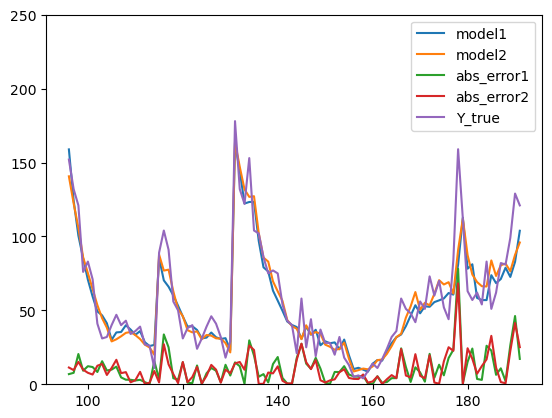

In [35]:
import matplotlib.pyplot as plt
# Get Pred1,Pred2, TrueValues:
full_predict1,Y_true,_ = trainer1.testing(ds1.normalizer, training_mode =training_mode)
full_predict2,_,_ = trainer2.testing(ds2.normalizer, training_mode =training_mode)

inputs = [[x,y,x_c] for  x,y,x_c in ds1.dataloader[training_mode]]
X = torch.cat([x for x,_,_ in inputs],0)
X = ds1.normalizer.unormalize_tensor(inputs = X,feature_vect = True) # unormalize input cause prediction is unormalized 

naive = X[:,0,0].numpy()
pred1 = full_predict1[:,0,0].numpy()
pred2 = full_predict2[:,0,0].numpy()
ytrue = Y_true[:,0,0].numpy()
error_abs1 = np.abs(pred1-ytrue)
error_abs2 = np.abs(pred2-ytrue)
naive_error = np.abs(naive-ytrue)

gain2_out_of_1 = (error_abs2-error_abs1)/error_abs1
ax = pd.DataFrame({'model1':pred1,
              'model2':pred2,
              'abs_error1':error_abs1,
              'abs_error2':error_abs2,
              #'Gain21': gain2_out_of_1,
              'Y_true':ytrue 
              }).iloc[96:96*2]
ax.plot(ylim = [0,250])

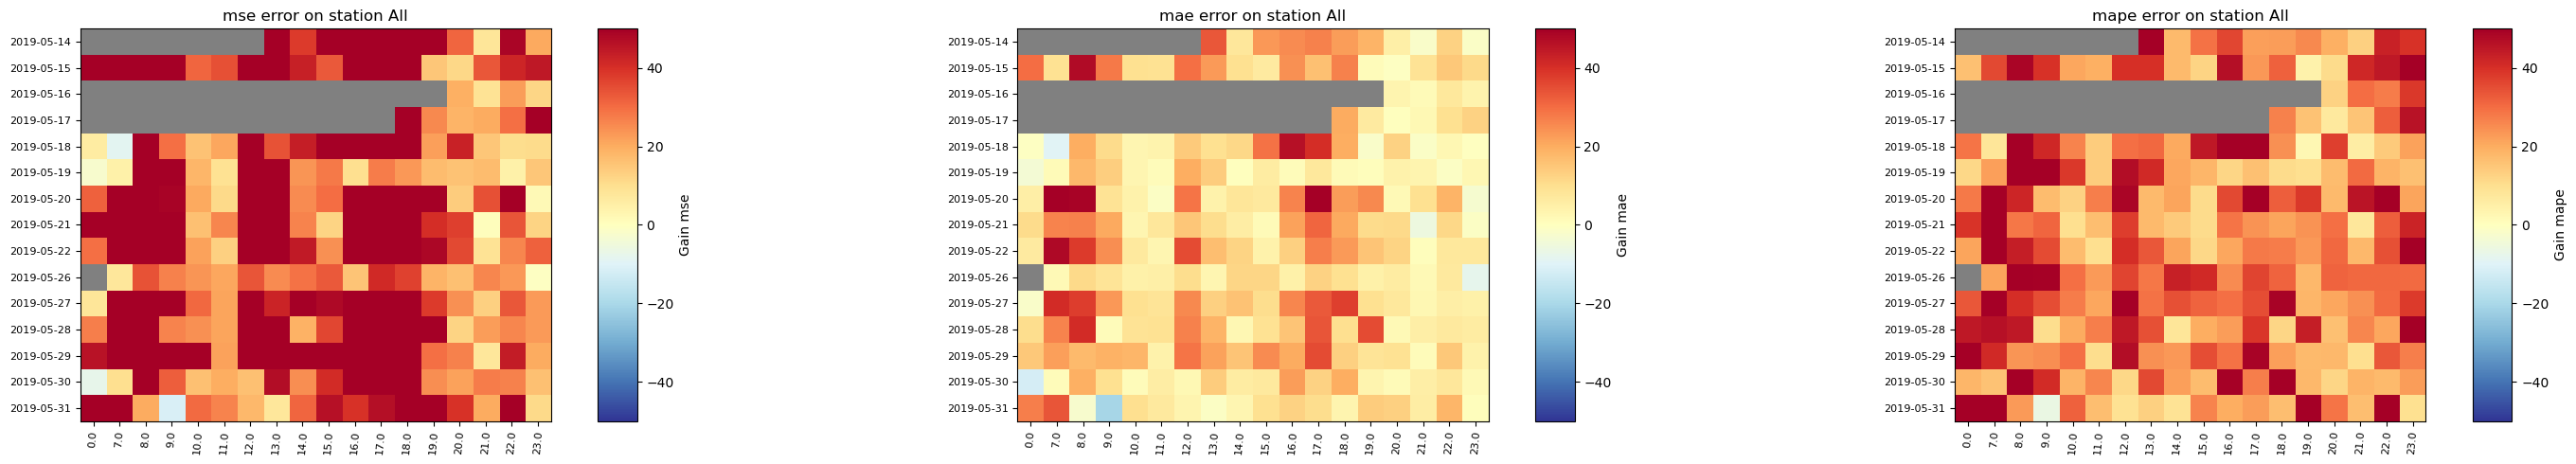

(<Figure size 3000x500 with 6 Axes>,
 array([<Axes: title={'center': 'mse error on station All'}>,
        <Axes: title={'center': 'mae error on station All'}>,
        <Axes: title={'center': 'mape error on station All'}>],
       dtype=object))

In [10]:
station = ['PAR','PER','GER','BON']
training_mode = 'test'

# index_matshow in :  ['weekday','hour','month_year','date','day_date']
# columns_matshow in :  [None, 'weekday','hour','month_year','date','day_date']

gain_between_models(trainer1,trainer2,ds1,ds2,training_mode,
                         metrics = ['mse','mae','mape'],
                        freq='1h',
                        index_matshow = 'date',
                        columns_matshow = 'hour',
                        min_flow = 20,
                        limit_percentage_error = 50,
                        acceptable_error = 10,
                        stations = station,
                        plot_each_station = False,
                        plot_all_station = True)

## Visualisation des coeff d'attentions :

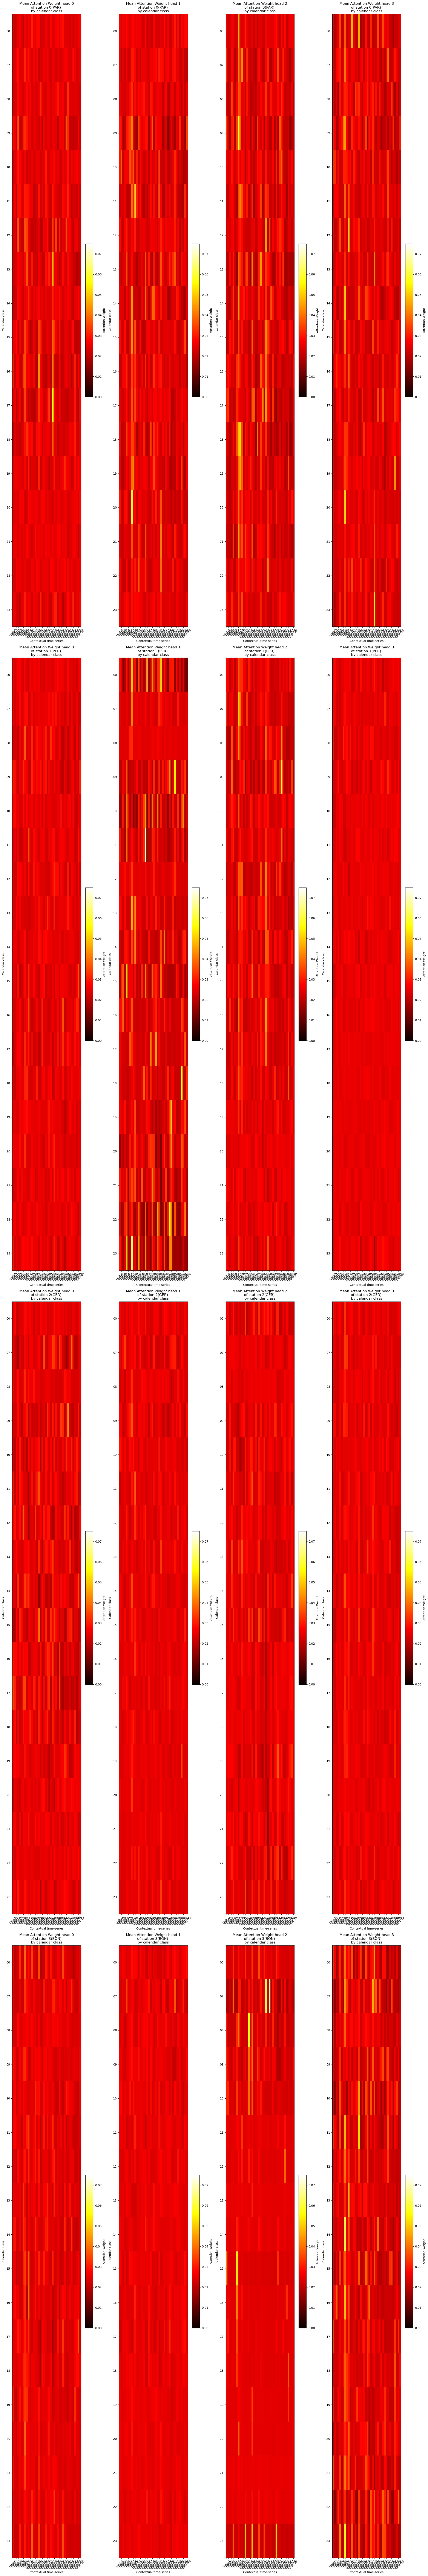

In [39]:
from plotting.plotting import plot_attn_weight
from constants.paths import CALENDAR_TYPE
nb_calendar_data = len(CALENDAR_TYPE)
temporal_agg = 'hour'  # weekday_hour_minutes','hour','weekday','weekday_hour'
plot_attn_weight(trainer2,nb_calendar_data,ds1,training_mode = training_mode,stations= station,temporal_agg =temporal_agg,save=None)